# Cell2Cell Group Assignment
*Class*: Marketing Analytics (EWMBA263 -1)  
*Team*: Albert Deng, Peter Pang, Alex Im, and DJ Prahladka

## 0. Data Initialization

Initialize CSV data

In [75]:
import pandas
import shared.mba263 as mba263
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

data = pandas.read_csv('shared/cell2cell.csv')
data.head(10)

# Interpolate missing values with average
data = data.fillna(data.mean())

Read in variable documentation

In [76]:
# Read supplementation documentation and statistics about each variable
docs = pandas.read_excel('Cell2Cell_Data_Documentation.xlsx', sheet_name='Sheet1', usecols='A:B,D:I', skiprows=range(0, 5), header=0)
docs.head()

,Position,Variable Name,Variable Descriptiion,N,Minimum,Maximum,Mean,Standard Deviation
0,1,customer,Customer ID,71047,1.000001e+06,1099999.00,1.050487e+06,29199.114811
1,2,calibrat,Calibration sample = 1; Validation sample = 0;,71047,0.000000e+00,1.00,5.630076e-01,0.496018
2,3,churn,Churn between 31-60 days after obs_date,71047,0.000000e+00,1.00,2.900756e-01,0.453800
3,4,churndep,Churn (=missing for validation sample),40000,0.000000e+00,1.00,5.000000e-01,0.500006
4,5,revenue,Mean monthly revenue,70831,-6.167500e+00,1223.38,5.885280e+01,44.243583


## 1. Data Selection and Analysis
### a) Variable Definition

Load all variables from the dataset and classify as different types for analysis.

In [77]:
all_variables = ['revenue','mou','recchrge','directas','overage','roam','changem',
                 'changer','dropvce','blckvce','unansvce','custcare','threeway',
                 'mourec','outcalls','incalls','peakvce','opeakvce','dropblk','callfwdv',
                 'callwait','months','uniqsubs','actvsubs','phones','models','eqpdays',
                 'age1','age2','children','credita','creditaa','prizmrur','prizmub',
                 'prizmtwn','refurb','webcap','truck','rv','occprof','occcler','occcrft',
                 'occstud','occhmkr','occret','occself','ownrent','marryun','marryyes',
                 'mailord','mailres','mailflag','travel','pcown','creditcd','retcalls',
                 'retaccpt','newcelly','newcelln','refer','incmiss','income','mcycle',
                 'setprcm','setprc','retcall']

Transform some variables based on observed idiosyncrasies. Specifically, we note:
1) All values of "marryun" are included in "marryyes" = 0, whereas not all values of "marryyes" = 0 correspond to "marryun" - we transform this to create three indicators, unknown marriage status, non-married, and married.
2) We note a perfect correlation between incmiss and income, since income = 0 means income is unknown. We therefore decide to transform income into deciles, with 0 indicating that it is missing.

In [78]:
# Transform marriage variables
# Set 'married_unk' equal to 1 when marryun = 1 and set it equal to 0 when marryun = 0
data['married_unk'] = data['marryun']
data['married_no'] = np.where((data['marryun'] == 0) & (data['marryyes'] == 0), 1, 0)
data['married_yes'] = data['marryyes']

# Transform income into deciles
income_dummies = pandas.get_dummies(data['income'], prefix='income')
income_dummies = income_dummies.drop(columns=['income_0']) # This is identical to incmissing
data = pandas.concat([data, income_dummies], axis=1)

# Clean up regression variables and add new ones
old_cols = ['marryun', 'marryyes', 'income']
new_cols = ['married_unk', 'married_no', 'married_yes']
new_cols.extend(income_dummies.columns.tolist())
all_variables = [var for var in all_variables if var not in old_cols]
all_variables.extend(new_cols)

print(all_variables)

['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'age1', 'age2', 'children', 'credita', 'creditaa', 'prizmrur', 'prizmub', 'prizmtwn', 'refurb', 'webcap', 'truck', 'rv', 'occprof', 'occcler', 'occcrft', 'occstud', 'occhmkr', 'occret', 'occself', 'ownrent', 'mailord', 'mailres', 'mailflag', 'travel', 'pcown', 'creditcd', 'retcalls', 'retaccpt', 'newcelly', 'newcelln', 'refer', 'incmiss', 'mcycle', 'setprcm', 'setprc', 'retcall', 'married_unk', 'married_no', 'married_yes', 'income_1', 'income_2', 'income_3', 'income_4', 'income_5', 'income_6', 'income_7', 'income_8', 'income_9']


Classify remaining variables as different types for analysis.

In [79]:
# Classify variable types as continuous, decile, or indicator and separate into different lists
def classify_variables(variables):
    continuous = []
    indicator = []

    for variable in variables:
        if data[variable].max() == 1 and data[variable].min() == 0:
            indicator.append(variable)
        else:
            continuous.append(variable)
    return continuous, indicator

# Classify variable types
continuous_variables, indicator_variables = classify_variables(all_variables)

### b) Exploratory Data Analysis
Review each variable segmented by churn rate to see which variables demonstrate statistically significant impacts on churn.

In [80]:
# Convert all continuous variables into deciles
continuous_decile_variables = []
for variable in continuous_variables:
    data[variable+'_decile'] = mba263.ntile(data[variable], 10)
    continuous_decile_variables.append(variable+'_decile')

# Evaluate the possibility of additional variables and add them to the model
# This will be populated later as new variables are added
additional_variables = []

# Split datasets into test and train
train = data.loc[data['calibrat'] == 1]
test = data.loc[data['calibrat'] == 0]

#### Indicator Variables
Run Chi-squared test across all indicator variables to identify variables with significant p-values (less than 0.05)

In [81]:
# Initialize a dictionary to store the p-values
p_values = {}
significant_indicator_variables = []

for variable in indicator_variables:
    # Creating a contingency table
    contingency_table = pandas.crosstab(train[variable], train['churn'])
    
    # Performing the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Storing the p-value associated with the variable
    p_values[variable] = p
   
    if p < 0.025:
        significant_indicator_variables.append(variable)

# Displaying the p-values
print(significant_indicator_variables)

# Since the training set is unbalanced and has a higher percentage of churners, 
# we look at summary statistics for the significant variables in the test set
for variable in significant_indicator_variables:
    grouped_data = test.groupby(variable)['churn'].mean()
    print(grouped_data)
    # Calculate means
    mean_0 = grouped_data.loc[0]
    mean_1 = grouped_data.loc[1]

    # Calculate the percentage of mean_1 as a percentage of mean_0 and vice versa
    percent_1_of_0 = (mean_1 / mean_0) * 100
    percent_0_of_1 = (mean_0 / mean_1) * 100
    
    print(max(percent_1_of_0,percent_0_of_1))


['credita', 'creditaa', 'prizmtwn', 'refurb', 'webcap', 'ownrent', 'mailord', 'mailres', 'creditcd', 'newcelly', 'incmiss', 'setprcm', 'retcall', 'married_unk', 'married_no']
credita
0    0.019823
1    0.017900
Name: churn, dtype: float64
110.74489980140818
creditaa
0    0.020642
1    0.013403
Name: churn, dtype: float64
154.0086065691086
prizmtwn
0    0.018962
1    0.023398
Name: churn, dtype: float64
123.39524473721124
refurb
0    0.018947
1    0.023971
Name: churn, dtype: float64
126.51488391966956
webcap
0    0.028138
1    0.018803
Name: churn, dtype: float64
149.6420268221137
ownrent
0    0.019118
1    0.020635
Name: churn, dtype: float64
107.93171392665609
mailord
0    0.020592
1    0.017938
Name: churn, dtype: float64
114.7944439126332
mailres
0    0.020528
1    0.018148
Name: churn, dtype: float64
113.11061779983169
creditcd
0    0.020255
1    0.019310
Name: churn, dtype: float64
104.89423268808622
newcelly
0    0.019710
1    0.019218
Name: churn, dtype: float64
102.56227350554

Based on these results, we determine that: 
 1) People that do not have a 'A' credit rating (creditaa = 0) are 10% more likely to churn, 
 2) People that do not have a 'AA' credit rating (creditaa = 0) are 54% more likely to churn, 
 3) People from 'towns' are 23% more likely to churn,
 4) People that have a refurbished phone are 26% more likely to churn,
 5) People without a web capable handset (webcap = 0) are 50% more likely to churn,
 6) People whose home ownership info is missing are 8% more likely to churn,
 7) People whose marital status is unkown are 4% more likely to churn,
 8) People who do not buy via mail order are 15% more likely to churn,
 9) People who do not respond to mails are 13% more likely to churn,
 10) People that do not own a credit card are 5% more likely to churn,
 11) People that are not known to be a "new cell phone user" are 3% more likely to churn
 12) People whose income is missing are 12% more likely to churn
 13) People whose handset price data is missing are 22% more likely to churn
 14) People who have made a call to the retention team are 82% more likely to churn

#### Continuous Variables
Transform them into deciles to see if certain deciles in these variables create a "jump" that indicates a significant difference in churn at a specific level. If so, we will create an indicator variable around it.

['revenue_decile', 'mou_decile', 'recchrge_decile', 'directas_decile', 'overage_decile', 'roam_decile', 'changem_decile', 'changer_decile', 'dropvce_decile', 'blckvce_decile', 'unansvce_decile', 'custcare_decile', 'threeway_decile', 'mourec_decile', 'outcalls_decile', 'incalls_decile', 'peakvce_decile', 'opeakvce_decile', 'dropblk_decile', 'callfwdv_decile', 'callwait_decile', 'months_decile', 'uniqsubs_decile', 'actvsubs_decile', 'phones_decile', 'models_decile', 'eqpdays_decile', 'age1_decile', 'age2_decile', 'retcalls_decile', 'retaccpt_decile', 'refer_decile', 'setprc_decile']


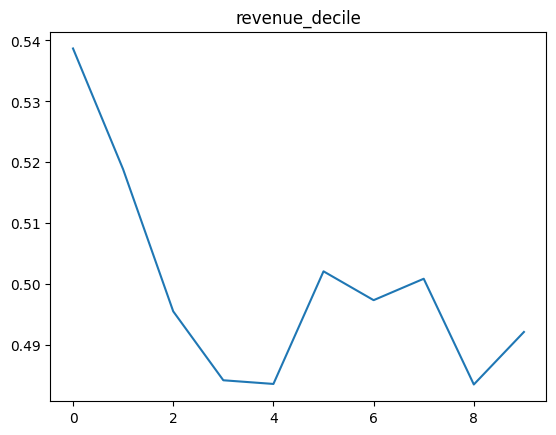

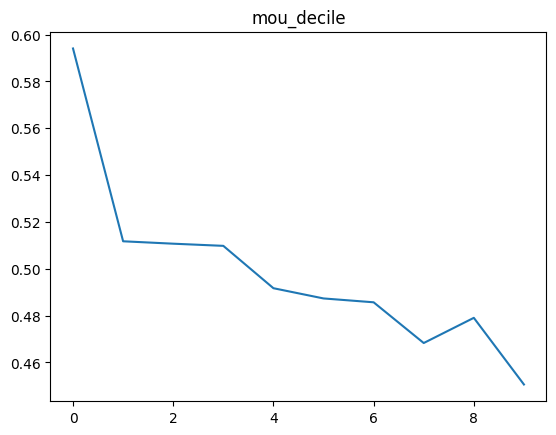

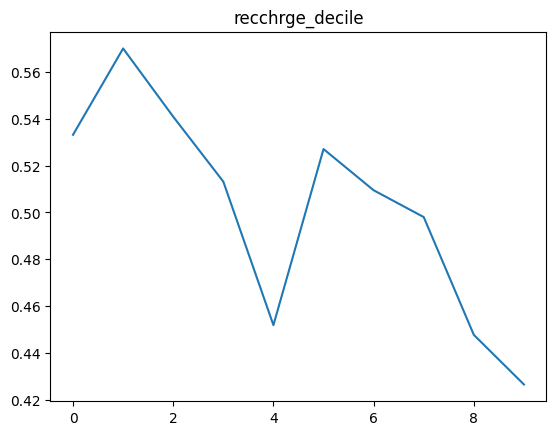

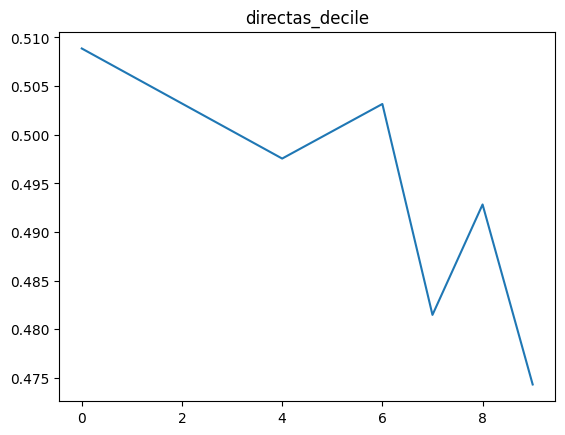

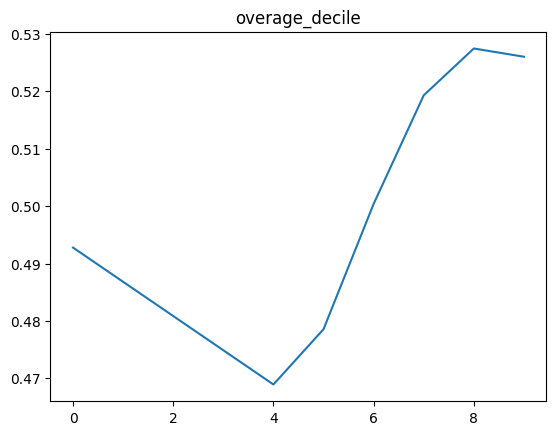

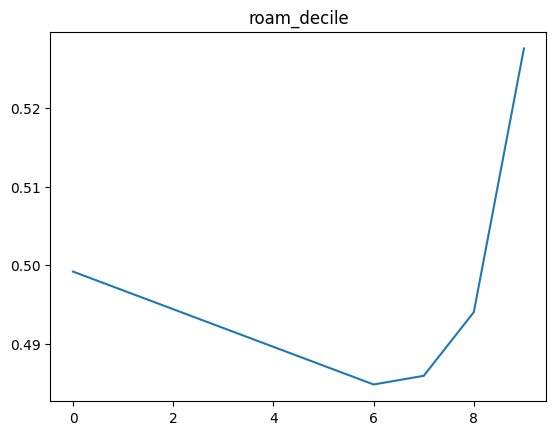

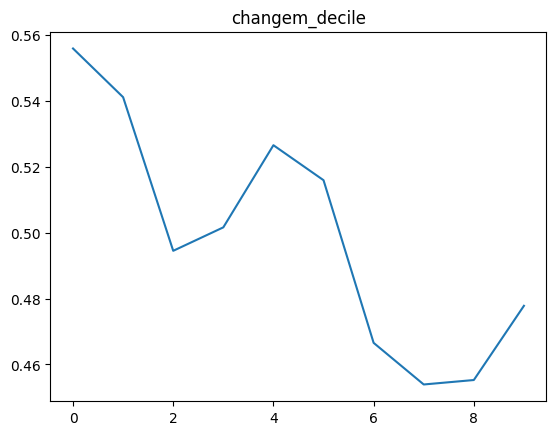

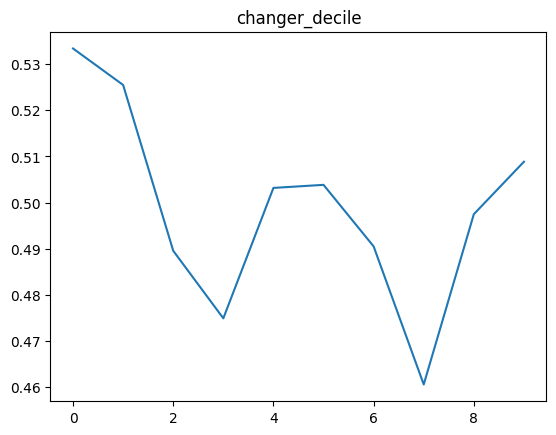

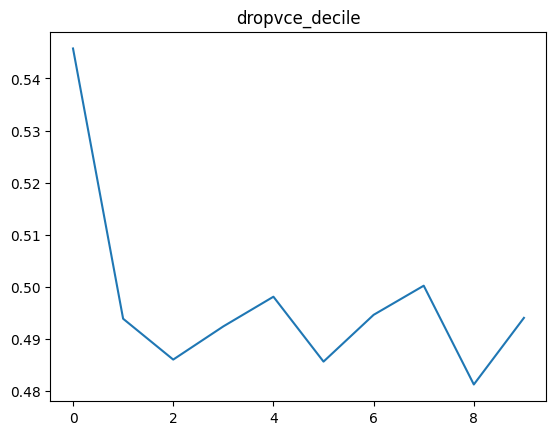

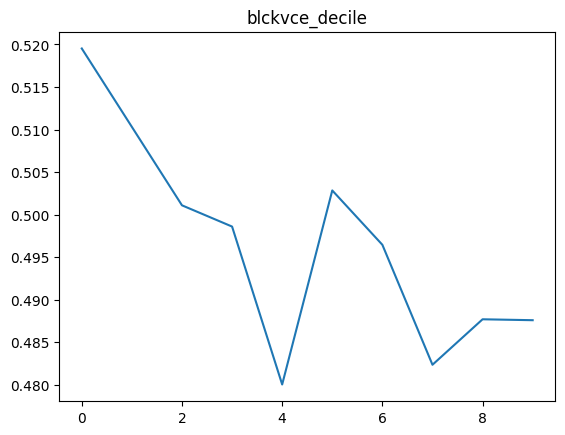

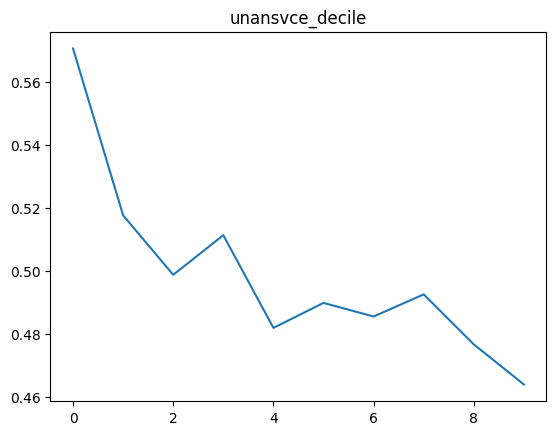

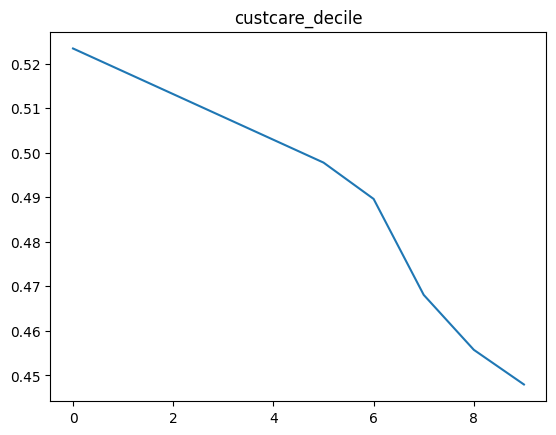

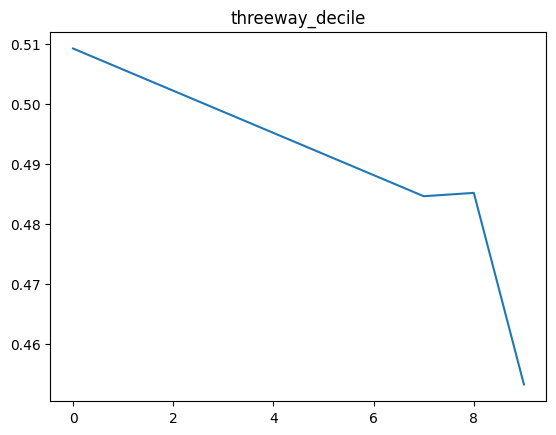

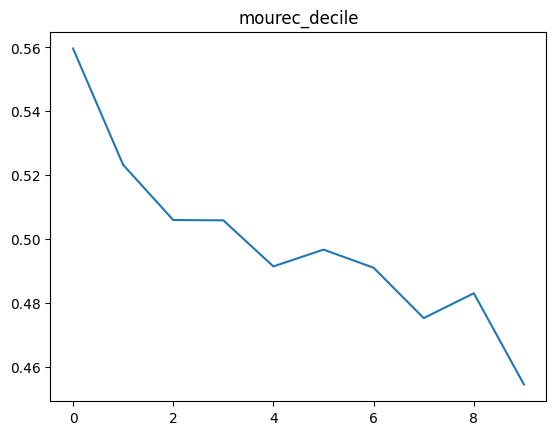

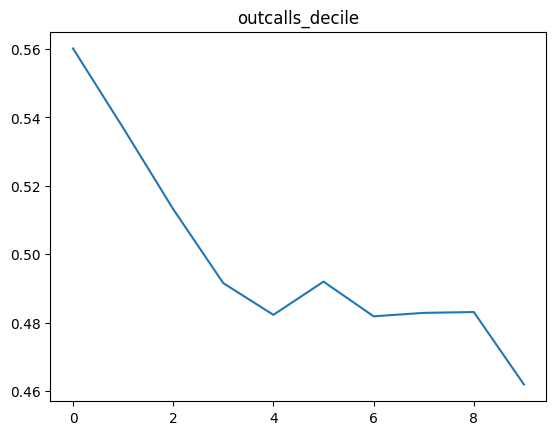

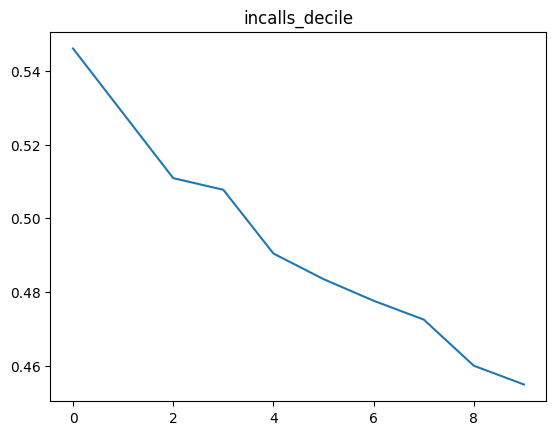

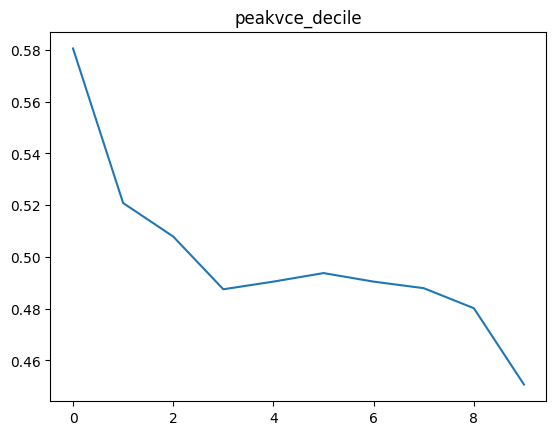

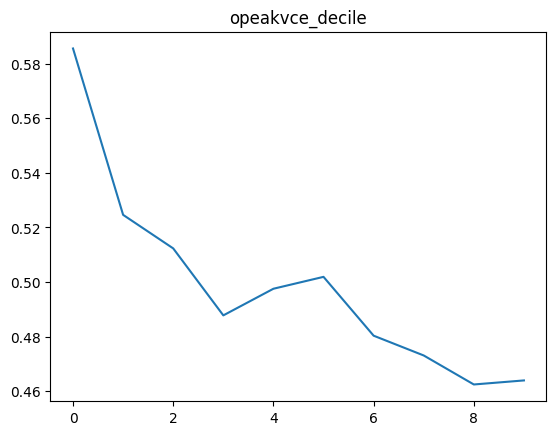

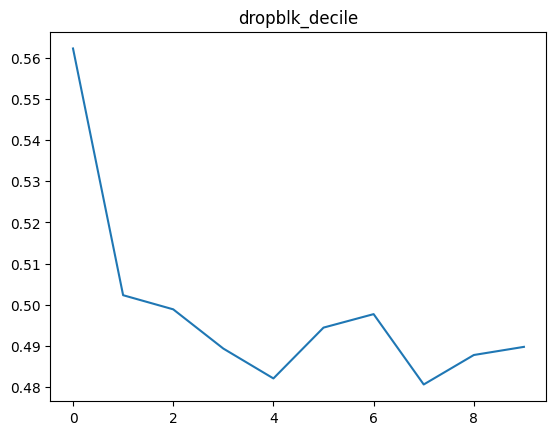

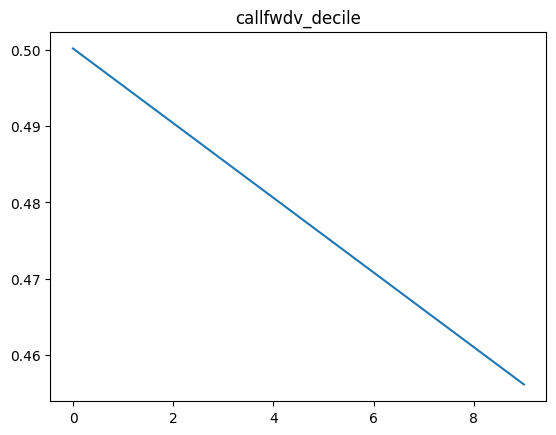

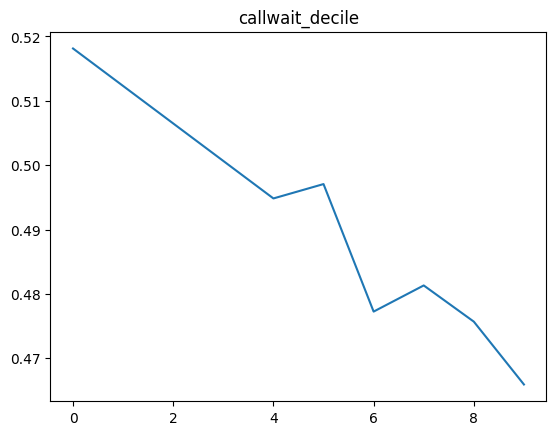

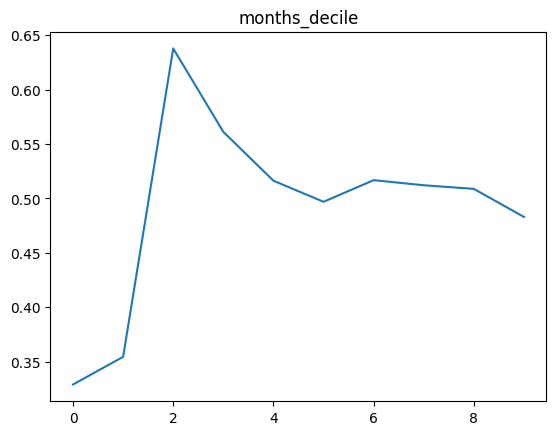

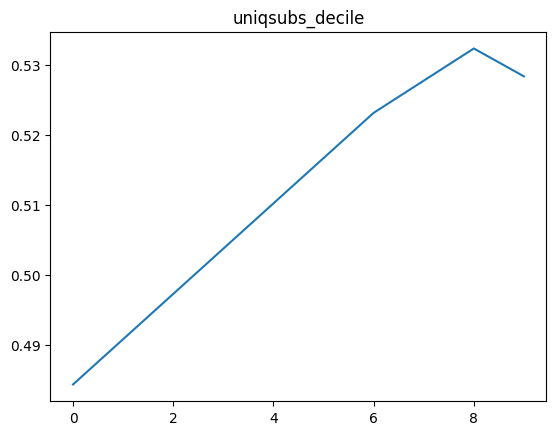

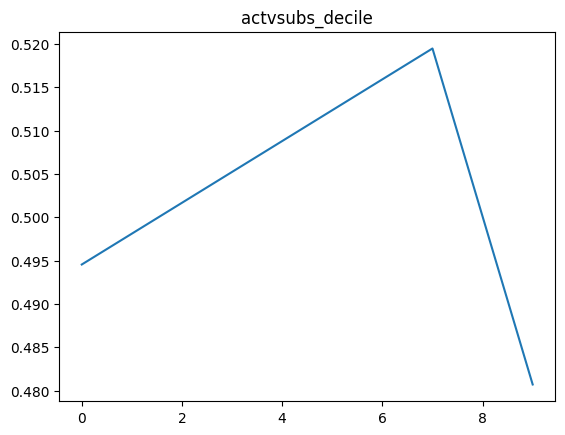

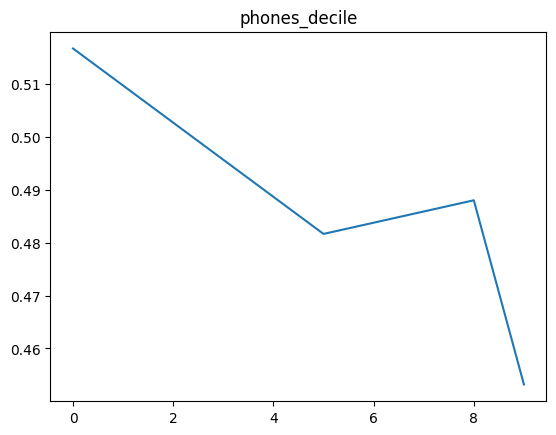

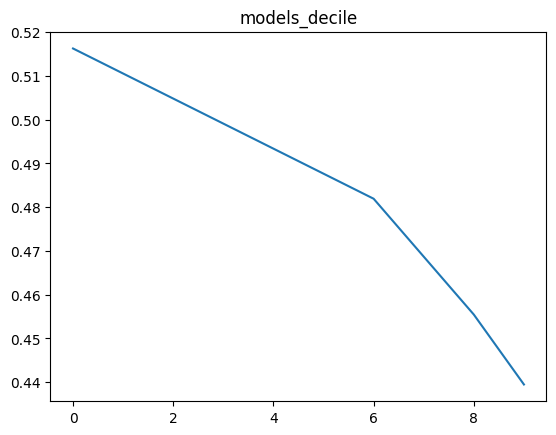

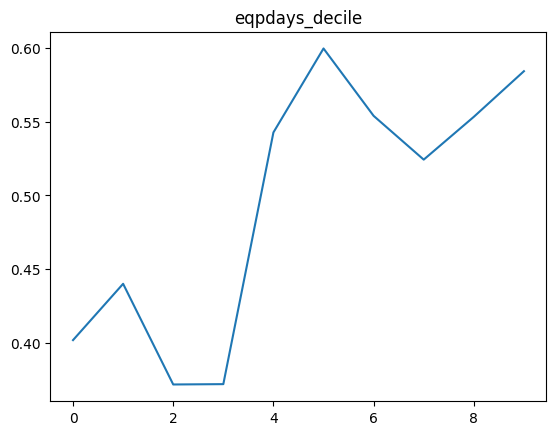

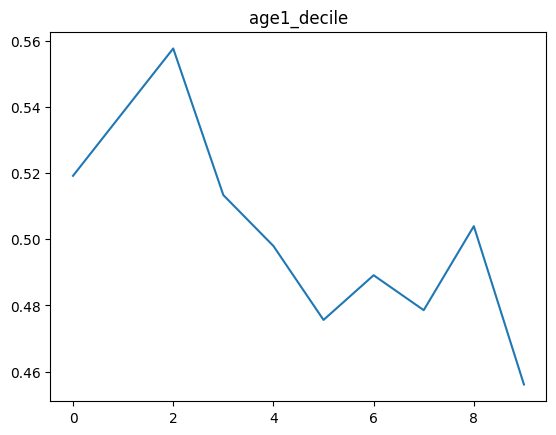

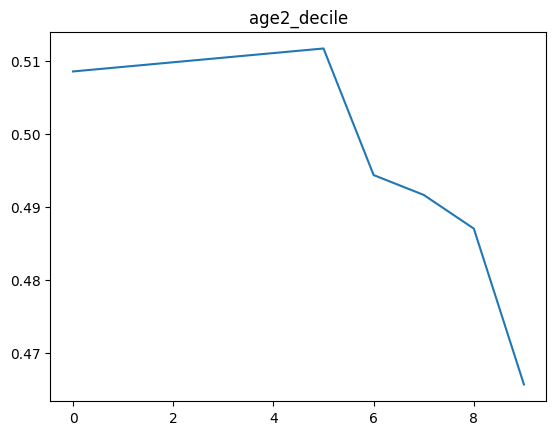

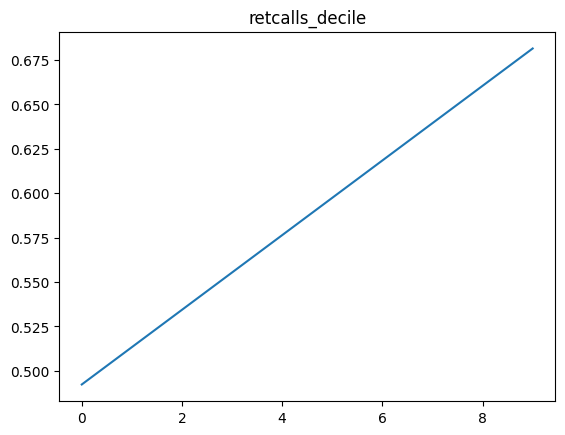

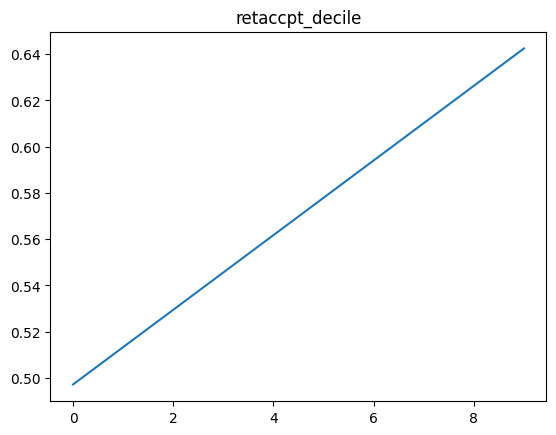

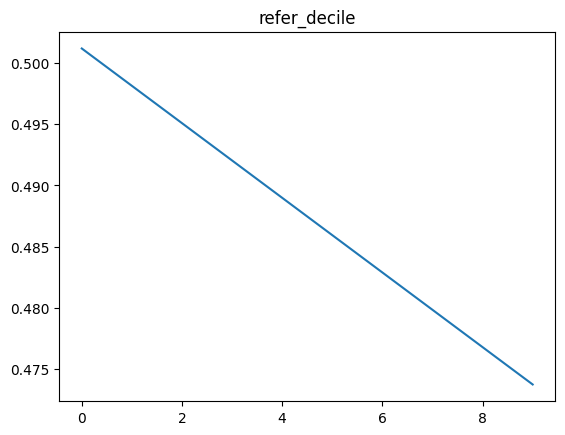

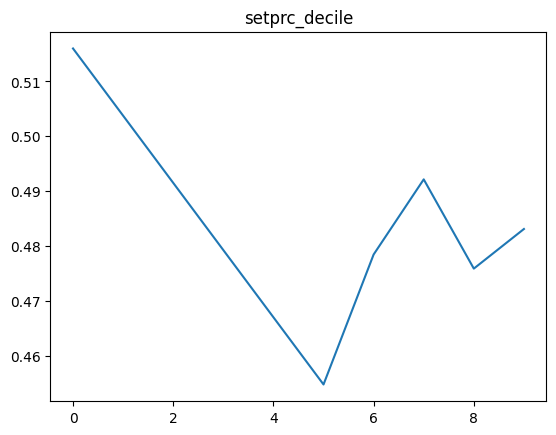

In [82]:
print(continuous_decile_variables)

# Look at the decile plots for all the continuous variables
for variable in continuous_decile_variables:
    plt.figure()
    plt.plot(train.groupby(variable)['churn'].mean())
    #plt.plot(train.groupby(variable)['customer'].count())
    plt.title(variable)

Transform non-linear variables into indicator variables based on thresholds where the churn rate deviates significantly

In [83]:
# For variables that appear to be non linear add indicator variables
train['months_dec_above_2'] = np.where(train['months_decile'] > 2, 1, 0)
train['overage_dec_above_4'] = np.where(train['overage_decile'] > 4, 1, 0)
train['roam_dec_above_8'] = np.where(train['roam_decile'] > 8, 1, 0)
train['dropvce_dec_above_0'] = np.where(train['dropvce_decile'] > 0, 1, 0)
train['eqpdays_dec_above_3'] = np.where(train['eqpdays_decile'] > 3, 1, 0)

test['months_dec_above_2'] = np.where(test['months_decile'] > 2, 1, 0)
test['overage_dec_above_4'] = np.where(test['overage_decile'] > 4, 1, 0)
test['roam_dec_above_8'] = np.where(test['roam_decile'] > 8, 1, 0)
test['dropvce_dec_above_0'] = np.where(test['dropvce_decile'] > 0, 1, 0)
test['eqpdays_dec_above_3'] = np.where(test['eqpdays_decile'] > 3, 1, 0)

data['months_dec_above_2'] = np.where(data['months_decile'] > 2, 1, 0)
data['overage_dec_above_4'] = np.where(data['overage_decile'] > 4, 1, 0)
data['roam_dec_above_8'] = np.where(data['roam_decile'] > 8, 1, 0)
data['dropvce_dec_above_0'] = np.where(data['dropvce_decile'] > 0, 1, 0)
data['eqpdays_dec_above_3'] = np.where(data['eqpdays_decile'] > 3, 1, 0)

non_linear_indicators = ['eqpdays_dec_above_3','months_dec_above_2'
                         ,'overage_dec_above_4','roam_dec_above_8','dropvce_dec_above_0']

# Iterate over each additional indicator to evaluate significance
for variable in non_linear_indicators:
    contingency_table = pandas.crosstab(train[variable], train['churn']) 
    # Performing the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(p)

    grouped_data = test.groupby(variable)['churn'].mean()
    print(grouped_data)

    mean_0 = grouped_data.loc[0]
    mean_1 = grouped_data.loc[1]

    # Calculate the percentage of mean_1 as a percentage of mean_0 and vice versa
    percent_1_of_0 = (mean_1 / mean_0) * 100
    percent_0_of_1 = (mean_0 / mean_1) * 100

    print(max(percent_1_of_0,percent_0_of_1))

additional_variables.extend(non_linear_indicators)

# Remove continuous versions of the variables now that we have indicators
old_vars = ['eqpdays', 'months', 'overage', 'roam', 'dropvce']
continuous_variables = [var for var in continuous_variables if var not in old_vars]

print(additional_variables)

1.2176050349452356e-216
eqpdays_dec_above_3
0    0.013289
1    0.024610
Name: churn, dtype: float64
185.1934936137576
5.824165399367217e-16
months_dec_above_2
0    0.018050
1    0.020425
Name: churn, dtype: float64
113.161559193771
2.235081288470518e-05
overage_dec_above_4
0    0.018762
1    0.020491
Name: churn, dtype: float64
109.21213649575938
0.00022879296695985695
roam_dec_above_8
0    0.019794
1    0.017980
Name: churn, dtype: float64
110.09172762352696
3.5428924985231848e-15
dropvce_dec_above_0
0    0.024396
1    0.018812
Name: churn, dtype: float64
129.68267681289169
['eqpdays_dec_above_3', 'months_dec_above_2', 'overage_dec_above_4', 'roam_dec_above_8', 'dropvce_dec_above_0']


We observe that all of these indicator variables are significant and should be added to the model. We therefore remove the continuous versions of these variables and load the indicators in instead.

### c) Variable Selection

Merge all selected variables from the previous analysis into the variables for analysis.

In [84]:
# Append sig_indicator_variables, decile_variables, and continuous variables together
selected_variables = np.concatenate((significant_indicator_variables, continuous_variables, additional_variables), axis=None)

## 2. Run analyses
### a) Build model
Define helper functions to calculate lift and identify the probability threshold.

In [85]:
# Create a custom scoring function to calculate lift
def calculate_lift(dataset, predict, actual, threshold):
   # Calculate the average churn based on where the predict column's value is greater than the threshold
   pred_rate = dataset[dataset[predict] > threshold][actual].mean()
   actual_rate = dataset[actual].mean()
   return (pred_rate / actual_rate)*100

# Define a function that finds the probability where the lift is greater than a target
def find_prob_threshold(dataset, predict, actual, target):
    thresholds = np.linspace(0, 1, 100)
    df = dataset[[predict, actual]]
    for threshold in thresholds:
        df['pred'] = np.where(df[predict] > threshold, 1, 0)
        if calculate_lift(df, 'pred', actual, threshold) >= target:
            return threshold

We run two standard linear regressions, one using our selected variables and one naive regression using the supplied data as-is. We then evaluate the lift for each to determine whether our selected variables are an improvement over the original variables.

In [86]:
### A function to run a logistic regression, a logistic regression w/ regularization, 
### a neural network, and a random forest
### Function adds two columns, p for probability and res if selected for targeting
def run_ml_models(dataset, actual, variables, target):
    df = dataset.copy()

    # Split dataset into train and test based on whether calibrat = 0 or 1
    train, test = data[data['calibrat'] == 1], data[data['calibrat'] == 0]

    ### Use a regular logistic regression
    ### ------------------------------------------------
    result_logit = mba263.logit(train[actual], train[variables])

    train['p_log'] = result_logit.predict(train[variables])
    test['p_log'] = result_logit.predict(test[variables])

    train_threshold = find_prob_threshold(train, 'p_log', actual, target)
    test_threshold = find_prob_threshold(test, 'p_log', actual, target)

    train['res_log'] = np.where(train['p_log'] > train_threshold, 1, 0)
    test['res_log'] = np.where(test['p_log'] > test_threshold, 1, 0)

    # Rename churn to actuals
    train['actual_res'] = train['churn']
    test['actual_res'] = test['churn']

    # Return three items, the results on the test dataset, the results on the training, the models, and thresholds
    return [test[['customer', 'p_log','actual_res', 'res_log']],
            train[['customer', 'p_log','actual_res', 'res_log']], 
               [result_logit],
               [train_threshold, test_threshold]]

In [87]:
predictions, actuals, model, thresholds = run_ml_models(data, 'churn', selected_variables, 170)
bench_predictions, bench_actuals, bench_model, bench_thresholds = run_ml_models(data, 'churn', all_variables, 170)

Optimization terminated successfully.
         Current function value: 0.664111
         Iterations 5
         Current function value: 0.670721
         Iterations: 35


## 3. Evaluation
### a) Evaluate model characteristics
Print parameters, coefficients, and odds for the resulting model

In [88]:
from IPython.display import display

# Print the coefficients for the logistic regressions
def print_coefs(models):
    display(models[0].summary())

print("Train threshold: {0:.2f}".format(thresholds[0]))
print("Test threshold: {0:.2f}".format(thresholds[1]))
print_coefs(model)

Train threshold: 0.92
Test threshold: 0.58


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                  churn   No. Observations:                40000
Model:                    Mba263Logit   Df Residuals:                    39946
Method:                           MLE   Df Model:                           53
Date:                Sun, 07 Apr 2024   Pseudo R-squ.:                 0.04189
Time:                        12:32:59   Log-Likelihood:                -26564.
converged:                       True   LL-Null:                       -27726.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1116      0.096      1.161      0.246      -0.077       0.300
credita                -0.1464      0.035     -4.158      0.000      -0.215      -0.077
creditaa               -0.3172      0.034     -9.280      0.000      -0.384      -0.250
prizmtwn                0.0618      0.029      2.115      0.034       0.005       0.119
refurb                  0.2244      0.032      7.039      0.000       0.162       0.287
webcap                 -0.2363      0.037     -6.310      0.000      -0.310      -0.163
ownrent                -0.0054      0.042     -0.128      0.898      -0.088       0.077
mailord                 0.0192      0.086      0.224      0.823      -0.149       0.187
mailres                -0.1265      0.086     -1.475      0.140      -0.295       0.042
creditcd                0.0147      0.044      0.337      0.736      -0.071       0.100
newcelly               -0.0545      0.026     -2.065      0.039      -0.106      -0.003
incmiss                -0.0550      0.053     -1.046      0.296      -0.158       0.048
setprcm                -0.1357      0.040     -3.355      0.001      -0.215      -0.056
retcall                 0.7338      0.191      3.834      0.000       0.359       1.109
married_unk             0.0273      0.035      0.786      0.432      -0.041       0.095
married_no             -0.0609      0.031     -1.964      0.049      -0.122      -0.000
revenue                 0.0023      0.001      3.006      0.003       0.001       0.004
mou                    -0.0004   5.04e-05     -7.402      0.000      -0.000      -0.000
recchrge               -0.0031      0.001     -3.479      0.001      -0.005      -0.001
directas               -0.0018      0.006     -0.315      0.753      -0.013       0.010
overage                 0.0004      0.000      1.553      0.120      -0.000       0.001
roam                    0.0041      0.002      2.035      0.042       0.000       0.008
changem                -0.0005   5.32e-05     -8.817      0.000      -0.001      -0.000
changer                 0.0021      0.000      5.805      0.000       0.001       0.003
dropvce                 0.0135      0.005      2.467      0.014       0.003       0.024
blckvce                 0.0086      0.005      1.610      0.108      -0.002       0.019
unansvce                0.0011      0.000      2.494      0.013       0.000       0.002
custcare               -0.0040      0.002     -1.613      0.107      -0.009       0.001
threeway               -0.0273      0.011     -2.443      0.015      -0.049      -0.005
mourec                  0.0002      0.000      1.774      0.076   -2.43e-05       0.000
outcalls                0.0013      0.001      2.166      0.030       0.000       0.002
incalls                -0.0032      0.001     -3.034      0.002      -0.005      -0.001
peakvce                -0.0007      0.000     -3.068      0.002      -0.001      -0.000
opeakvce            -3.101e-05      0.000     -0.118      0.906      -0.0

### b) Analyze Gains
Determine whether the selected variables outperforms the all variables regression - we want the red line to exceed the blue line in earlier deciles

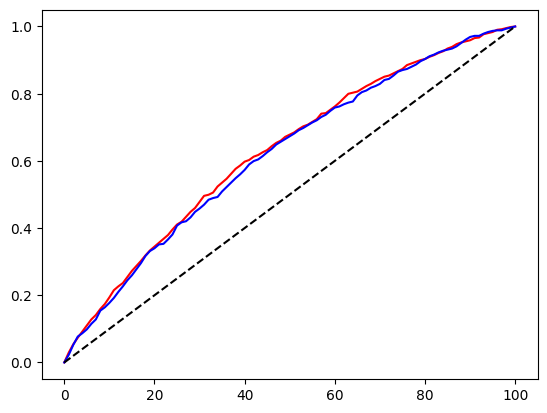

In [89]:
gain = mba263.gain(predictions['actual_res'], predictions['p_log'], bins=100)
bench_gain = mba263.gain(bench_predictions['actual_res'], bench_predictions['p_log'], bins=100)

plt.plot(gain, label='Selected Variables', color='red')
plt.plot(bench_gain, label='All Variables', color='blue')
plt.plot([0, 100], [0, 1], 'k--', label='Random')

We note an improvement as the red line exceeds the blue line at most points (only falling below the blue line after the 80th decile). This indicates that our model produces higher gains in earlier deciles, most pronounced at and below the 40th decile. 

### c) Analyze Lift
Begin by subdividing results into 100 n-tiles and identifying the point where the average lift becomes 170.

In [90]:
lift_ntiles = mba263.lift(predictions['actual_res'], predictions['p_log'], 100)
max_tile = 0
sum = 0

for i in range(0, 100):
    sum += lift_ntiles[i]
    if sum / (i + 1) > 170:
        max_tile = i
    else: 
        break

print("The maximum tile is: {}".format(max_tile))


The maximum tile is: 52


Draw a lift chart with a red line indicating what fraction of the data can be included to generate an average lift greater than 170. The greater the fraction, the stronger our predictive power (as we can apply our predictions to a larger population).

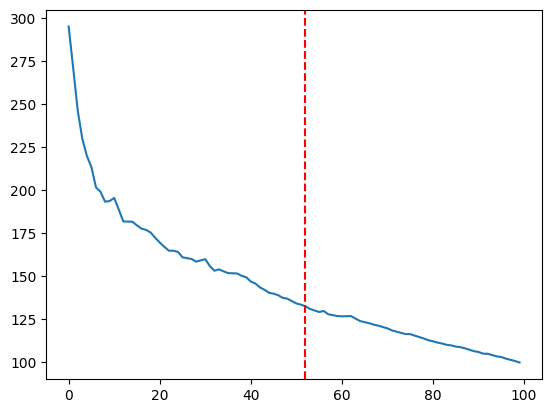

In [91]:
plt.plot(mba263.lift(predictions['actual_res'], predictions['p_log'], 100))
plt.axvline(x=max_tile, color='red', linestyle='--')

### c) Model Analysis
Review the economic importance of each predictor variable. Start with the odds ratios.

In [92]:
# Print the odds ratios for each logistic regression
def print_odds(models):
    display(mba263.odds_ratios(models[0]))

print_odds(model)

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
credita,0.863779,0.030419,4.478182,0.000,0.804767,0.922792
creditaa,0.728164,0.024892,10.920609,0.000,0.679873,0.776454
prizmtwn,1.063799,0.031105,2.051047,0.040,1.003454,1.124143
refurb,1.251563,0.039896,6.305538,0.000,1.174166,1.328961
webcap,0.789511,0.029570,7.118443,0.000,0.732146,0.846876
ownrent,0.994587,0.042063,0.128688,0.898,0.912985,1.076189
mailord,1.019363,0.087245,0.221935,0.824,0.850108,1.188617
mailres,0.881138,0.075603,1.572199,0.116,0.734469,1.027807
creditcd,1.014847,0.044400,0.334382,0.738,0.928710,1.100983
newcelly,0.946939,0.024997,2.122712,0.034,0.898445,0.995433


Normalize them against each variable's standard deviation

In [93]:
# Avoid truncation
pandas.set_option('display.max_rows', None)

# Retrieve odds and standard deviations
odds = mba263.odds_ratios(model[0])
x_std = docs[['Variable Name', 'Standard Deviation']]

# Join odds ratios against standard deviations
joined = odds.merge(x_std, left_index=True, right_on='Variable Name')

# Calculate normalized odds
joined['norm_odds'] = np.power(joined['Odds ratios'], joined['Standard Deviation'])

# Calculate magnitude (reverse direction for negative odds)
joined['mag_odds'] = joined['norm_odds']

# set mag_odds to 1/mag_odds if norm_odds is less than 1
joined.loc[joined['mag_odds'] < 1, 'mag_odds'] = 1 / joined['norm_odds']
joined = joined.sort_values('mag_odds', ascending=False)

joined[['Variable Name', 'mag_odds']]

,Variable Name,mag_odds
26,uniqsubs,1.231812
5,mou,1.218678
25,months,1.183605
30,eqpdays,1.162301
69,retcall,1.142302
27,actvsubs,1.138404
12,dropvce,1.129152
10,changem,1.127122
35,creditaa,1.111992
4,revenue,1.108053
